In [1]:
# =============================================================
# 0. Install & login
# =============================================================
!pip -q install datasets sentence-transformers scikit-learn tqdm huggingface_hub
!pip install --upgrade datasets

from huggingface_hub import notebook_login
notebook_login()                        # paste your HF token

# =============================================================
# 1. Imports & config
# =============================================================
from datasets import load_dataset, Dataset
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import numpy as np, pandas as pd, matplotlib.pyplot as plt, re, random, joblib
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder

SEED = 42
random.seed(SEED); np.random.seed(SEED)

HF_DESIGN_PROMPTS = "ireneom3/design-pattern-prompts"

# =============================================================
# 2. Load & merge datasets
# =============================================================
ct     = load_dataset("code_x_glue_ct_code_to_text", "python", split="train")
tc     = load_dataset("code_x_glue_tc_text_to_code",          split="train")
refine = load_dataset("code_x_glue_cc_code_refinement", "medium", split="train")
dp     = load_dataset(HF_DESIGN_PROMPTS, split="train")

def to_prompts(ds, field, tag):
    return [
        {"id": f"{tag}_{i}", "prompt": ex[field].strip()}
        for i, ex in enumerate(ds)
        if ex.get(field) and len(ex[field].strip()) >= 8
    ]

prompts = (
      to_prompts(ct, "docstring", "ct")
    + to_prompts(tc, "nl",        "tc")
    + [{"id": f"ref_{i}", "prompt": f"Fix the following buggy function:\n{ex['buggy'][:120]}…"}
       for i, ex in enumerate(refine)]
    + to_prompts(dp, "prompt",    "dp")
)

train_data = Dataset.from_list(prompts)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.2 MB/s eta 0:00:00


README.md: 0.00B [00:00, ?B/s]

python/train-00000-of-00002.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

python/train-00001-of-00002.parquet:   0%|          | 0.00/147M [00:00<?, ?B/s]

python/validation-00000-of-00001.parquet:   0%|          | 0.00/16.7M [00:00<?, ?B/s]

python/test-00000-of-00001.parquet:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/251820 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13914 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/14918 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/33.1M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/634k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/526k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

medium/train-00000-of-00001.parquet:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

medium/validation-00000-of-00001.parquet:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

medium/test-00000-of-00001.parquet:   0%|          | 0.00/1.49M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/52364 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6546 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6545 [00:00<?, ? examples/s]

data-00000-of-00001.arrow:   0%|          | 0.00/451k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3505 [00:00<?, ? examples/s]

In [2]:
# =============================================================
# 3. Heuristic labeling  (improved regex)
# =============================================================
pattern_rules = {
    "Reflection Loop": r"\b(fix|debug|error|retry)\b",
    "Design Pattern" : r"\b(factory|observer|strategy|singleton|adapter|decorator|composite|template method|command|mediator|bridge|pattern)\b",
    "Planner→Coder"  : r"\b(first.*then|plan|steps?)\b",
    "Bug Fix"        : r"\b(bug|wrong output|defect)\b",
    "Refactor"       : r"\b(refactor|clean up|rename)\b",
    "Data‑Pipeline"  : r"\b(etl|csv|json|load.*file|pipeline)\b",
    "Doc‑Generator"  : r"\b(docstring|generate docs|readme)\b",
    "Complex‑Algo"   : r"\b(dynamic programming|graph|dijkstra|bfs|dfs)\b",
    "Integration‑Test":r"\b(integration test|e2e|harness)\b"
}
fallback = re.compile(r"\b(class|plan|design)\b")

def heuristic(txt):
    p, hits = txt.lower(), set()
    if len(p.split()) < 12 and not fallback.search(p):
        return "Direct"
    for lab, rgx in pattern_rules.items():
        if re.search(rgx, p):
            hits.add(lab)
    if not hits: return "Direct"
    return ";".join(sorted(hits))

train_data = train_data.map(lambda ex: {"label": heuristic(ex["prompt"])})

# =============================================================
# 4. Hybrid balancing (undersample + oversample)
# =============================================================
MAX_CAP    = 5_000   # cut big classes
MIN_TARGET = 500     # boost small classes
from collections import defaultdict, Counter
buckets = defaultdict(list)
for idx, lbl in enumerate(train_data["label"]):
    buckets[lbl].append(idx)

balanced_idx = []
for lbl, idxs in buckets.items():
    if len(idxs) > MAX_CAP:
        balanced_idx += random.sample(idxs, MAX_CAP)
    else:
        balanced_idx += idxs

# oversample rare
counts = Counter([train_data["label"][i] for i in balanced_idx])
for lbl, cnt in counts.items():
    if cnt < MIN_TARGET:
        balanced_idx += random.choices(buckets[lbl], k=MIN_TARGET-cnt)

balanced_ds = train_data.select(balanced_idx).shuffle(seed=SEED)




Map:   0%|          | 0/407675 [00:00<?, ? examples/s]

In [3]:
#embedder   = SentenceTransformer("all-MiniLM-L6-v2")
embedder = SentenceTransformer("sentence-transformers/all-mpnet-base-v2",)
# Convert NumPy indices to Python integers before accessing the dataset
embeddings = embedder.encode([balanced_ds["prompt"][int(i)] for i in range(len(balanced_ds["prompt"]))], batch_size=64, show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/769 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


                                                       precision    recall  f1-score   support

                                              Bug Fix       0.93      0.69      0.79       125
                                 Bug Fix;Complex‑Algo       1.00      1.00      1.00       125
                                Bug Fix;Data‑Pipeline       1.00      1.00      1.00       125
                Bug Fix;Data‑Pipeline;Reflection Loop       1.00      1.00      1.00       125
                               Bug Fix;Design Pattern       1.00      1.00      1.00       125
               Bug Fix;Design Pattern;Reflection Loop       1.00      1.00      1.00       125
                                Bug Fix;Doc‑Generator       1.00      1.00      1.00       125
                                Bug Fix;Planner→Coder       0.99      1.00      1.00       125
                                     Bug Fix;Refactor       1.00      1.00      1.00       125
                              Bug Fix;Reflection 

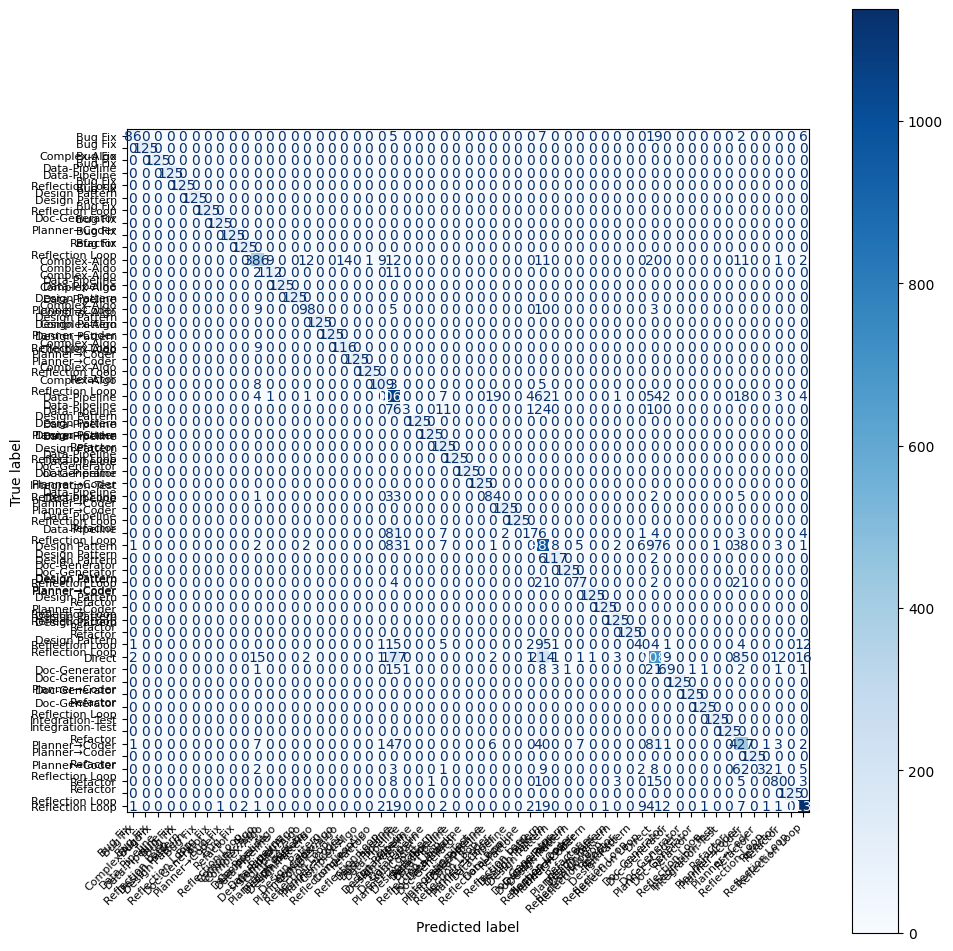

Saving the dataset (0/1 shards):   0%|          | 0/49169 [00:00<?, ? examples/s]

In [4]:
# =============================================================
# 5. Baseline Logistic Regression with Encoded Labels
# =============================================================

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

labels = list(balanced_ds["label"])  # list of string labels

# Split first (on string labels)
X_train, X_test, y_train_str, y_test_str = train_test_split(
    embeddings, labels, stratify=labels,
    test_size=0.25, random_state=SEED)

# Encode string labels → integers
le = LabelEncoder()
y_train = le.fit_transform(y_train_str)
y_test  = le.transform(y_test_str)

# Train on encoded labels
#clf = LogisticRegression(max_iter=2000, multi_class="multinomial",
#                         n_jobs=-1, random_state=SEED).fit(X_train, y_train)

from sklearn.calibration import CalibratedClassifierCV
base = LogisticRegression(max_iter=4000, multi_class="multinomial",
                           class_weight="balanced", C=4.0,
                           solver="lbfgs", n_jobs=-1, random_state=SEED)
clf  = CalibratedClassifierCV(base, cv=3, method="isotonic").fit(X_train, y_train)

# Evaluate (decode for human-readable report)
y_pred = clf.predict(X_test)
print(classification_report(y_test_str, le.inverse_transform(y_pred)))

# Confusion matrix with readable class names
_, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(
    y_test_str, le.inverse_transform(y_pred), ax=ax,
    cmap="Blues", xticks_rotation=45)
ax.set_xticklabels([t.get_text().replace(";", "\n") for t in ax.get_xticklabels()],
                   ha="right", fontsize=8)
ax.set_yticklabels([t.get_text().replace(";", "\n") for t in ax.get_yticklabels()],
                   fontsize=8)
plt.tight_layout(); plt.show()

# =============================================================
# 6. Save artifacts
# =============================================================

balanced_ds.save_to_disk("merged_strategy_dataset_balanced")
joblib.dump(clf, "strategy_selector_lr_balanced.joblib")
joblib.dump(le,  "label_encoder_balanced.joblib")
np.save("sbert_embeddings_balanced.npy", embeddings)

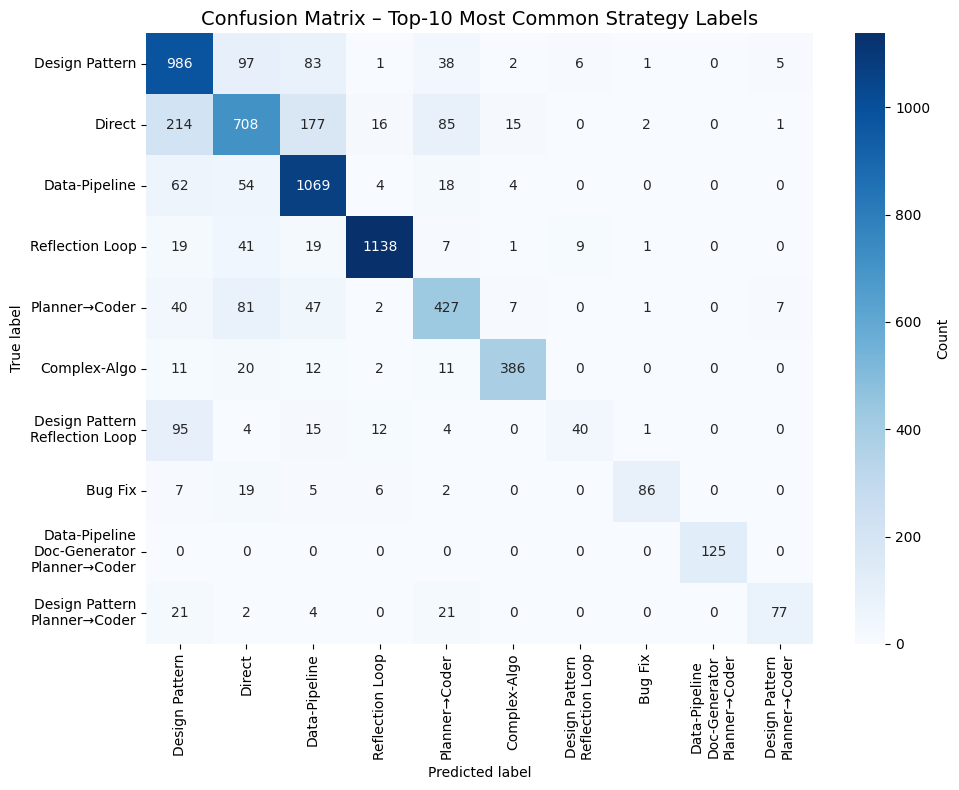

/tmp/ipython-input-958158930.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[t.replace(";", "\n") for t in top10], y=f1, palette="Blues_d")


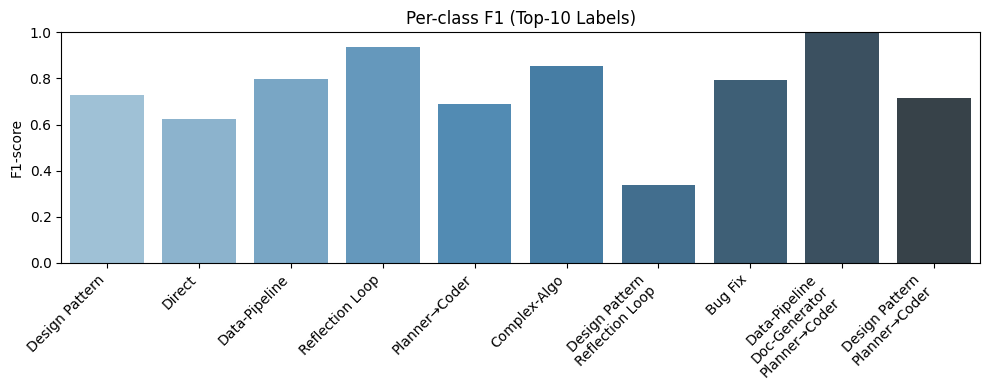

                                                       precision    recall  f1-score   support

                                              Bug Fix      0.935     0.688     0.793       125
                                Bug Fix;Planner→Coder      0.000     0.000     0.000         0
                              Bug Fix;Reflection Loop      0.000     0.000     0.000         0
                                         Complex‑Algo      0.930     0.791     0.855       488
                           Complex‑Algo;Data‑Pipeline      0.000     0.000     0.000         0
                          Complex‑Algo;Design Pattern      0.000     0.000     0.000         0
                           Complex‑Algo;Planner→Coder      0.000     0.000     0.000         0
                                Complex‑Algo;Refactor      0.000     0.000     0.000         0
                         Complex‑Algo;Reflection Loop      0.000     0.000     0.000         0
                                        Data‑Pipe

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [5]:
# =============================================================
# 5-B. Evaluation – presentation-friendly (top-10 labels only)
# =============================================================
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import numpy as np

# ------- already have:  y_test_str  and  y_pred -------------
y_pred_str = le.inverse_transform(y_pred)

# ---------- Choose top-10 labels by frequency in y_test ----------
top10 = [lbl for lbl, _ in collections.Counter(y_test_str).most_common(10)]

# Filter test set to those labels
mask = [l in top10 for l in y_test_str]
y_test_top = np.array(y_test_str)[mask]
y_pred_top = np.array(y_pred_str)[mask]

# Confusion matrix (10×10)
cm = confusion_matrix(y_test_top, y_pred_top, labels=top10)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True, fmt="d", cmap="Blues",
    xticklabels=[t.replace(";", "\n") for t in top10],
    yticklabels=[t.replace(";", "\n") for t in top10],
    cbar_kws={"label": "Count"}
)
plt.title("Confusion Matrix – Top-10 Most Common Strategy Labels", fontsize=14)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

# ---------- Bar chart of F1 for the same top-10 ----------
p, r, f1, _ = precision_recall_fscore_support(
    y_test_top, y_pred_top, labels=top10, zero_division=0
)

plt.figure(figsize=(10, 4))
sns.barplot(x=[t.replace(";", "\n") for t in top10], y=f1, palette="Blues_d")
plt.ylabel("F1-score")
plt.title("Per-class F1 (Top-10 Labels)")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Still print the full textual report if desired
print(classification_report(y_test_top, y_pred_top, digits=3))
